In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile
import shutil
import matplotlib.pyplot as plt
from IPython.display import clear_output

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
# Path to the dataset
zip_file_path = "/content/drive/MyDrive/dataset/archive-alz.zip"
dataset_extracted_path = "/content/input"

if not os.path.exists(dataset_extracted_path):
    os.makedirs(dataset_extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_extracted_path)
    print("Dataset extracted successfully.")
else:
    print("Dataset already extracted.")


Mounted at /content/drive
Dataset extracted successfully.


In [ ]:
dataset_path = os.path.join(dataset_extracted_path, "AugmentedAlzheimerDataset")
output_base = "/content/split_data"
train_dir, val_dir, test_dir = [os.path.join(output_base, d) for d in ["train", "val", "test"]]

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

def split_dataset(input_dir, output_dirs, test_size=0.2, val_size=0.1):
    valid_extensions = (".jpg", ".jpeg", ".png")
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path): continue

        images = [img for img in os.listdir(class_path) if img.endswith(valid_extensions)]
        train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=42)
        train_imgs, val_imgs = train_test_split(train_imgs, test_size=val_size/(1-test_size), random_state=42)

        for split, imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
            split_path = os.path.join(output_dirs[split], class_name)
            os.makedirs(split_path, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(split_path, img))

split_dataset(dataset_path, {"train": train_dir, "val": val_dir, "test": test_dir})
print("Dataset split completed.")


Dataset split completed.


In [ ]:

class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                self.images.append(os.path.join(class_path, img_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Create Dataloaders
train_loader = DataLoader(AlzheimerDataset(train_dir, transform), batch_size=32, shuffle=True)
val_loader = DataLoader(AlzheimerDataset(val_dir, transform), batch_size=32, shuffle=False)
test_loader = DataLoader(AlzheimerDataset(test_dir, transform), batch_size=32, shuffle=False)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
# Attention-Based Fusion Layer
class AttentionFusion(nn.Module):
    def __init__(self, densenet_dim, vit_dim):
        super(AttentionFusion, self).__init__()
        self.fc_densenet = nn.Linear(densenet_dim, 512)
        self.fc_vit = nn.Linear(vit_dim, 512)
        self.attention = nn.Softmax(dim=1)

    def forward(self, densenet_features, vit_features):
        densenet_proj = self.fc_densenet(densenet_features)
        vit_proj = self.fc_vit(vit_features)

        combined = torch.stack([densenet_proj, vit_proj], dim=1)
        weights = self.attention(combined.mean(dim=-1))

        fused_features = weights[:, 0].unsqueeze(1) * densenet_proj + weights[:, 1].unsqueeze(1) * vit_proj
        return fused_features


In [ ]:
class HybridDenseNetViT(nn.Module):
    def __init__(self, num_classes=4):
        super(HybridDenseNetViT, self).__init__()

        # DenseNet201 for local features
        self.densenet = models.densenet201(pretrained=True).features
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
        self.densenet_fc = nn.Linear(1920, 768)  # Map DenseNet output

        # Vision Transformer for global features
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit_output_size = 768  # CLS token embedding size

        # Attention-Based Fusion
        self.attention_fusion = AttentionFusion(768, 768)

        # Final classifier
        self.fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # DenseNet feature extraction
        densenet_features = self.densenet(x)  # Shape: [batch, 1920, 7, 7]
        densenet_features = self.gap(densenet_features).flatten(start_dim=1)  # Shape: [batch, 1920]
        densenet_mapped = self.densenet_fc(densenet_features)  # Map to CLS token size: [batch, 768]

        # Vision Transformer feature extraction
        vit_outputs = self.vit(x)  # Input to ViT
        vit_cls_token = vit_outputs.last_hidden_state[:, 0, :]  # CLS token: [batch, 768]

        # Residual connection
        vit_cls_token_residual = vit_cls_token + densenet_mapped  # Residual addition

        # Attention-based fusion
        fused_features = self.attention_fusion(vit_cls_token_residual, densenet_mapped)

        # Classification
        output = self.fc(fused_features)
        return output


In [ ]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridDenseNetViT(num_classes=4).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 193MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Huggin

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

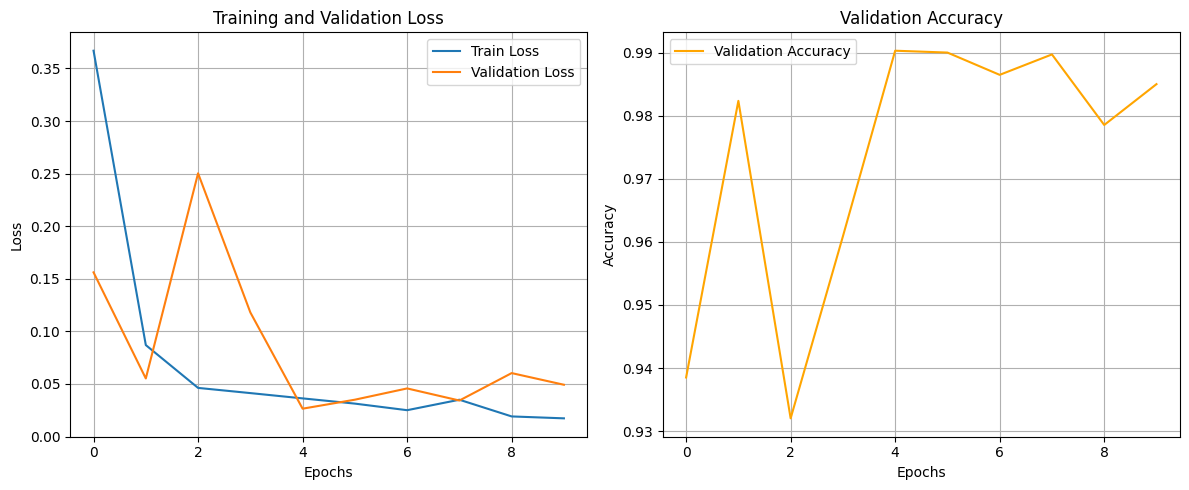

In [ ]:
# Initialize metrics dictionary
metrics = {
    'train_loss': [],
    'val_loss': [],
    'val_acc': []
}

# Initialize Matplotlib for interactive mode
plt.ion()  # Turn on interactive plotting

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Average training loss
    avg_train_loss = running_loss / len(train_loader)
    metrics['train_loss'].append(avg_train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            # Accumulate validation loss
            val_running_loss += val_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    # Average validation loss and accuracy
    avg_val_loss = val_running_loss / len(val_loader)
    val_acc = correct / total
    metrics['val_loss'].append(avg_val_loss)
    metrics['val_acc'].append(val_acc)

    # Print metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Real-time plotting
    clear_output(wait=True)  # Clear previous outputs for real-time updates

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics['val_acc'], label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.71%
